### Downloading MNIST using torchvision

In [85]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, sampler
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import PIL
import random as rnd
import seaborn as sns
from sklearn.manifold import TSNE

import sys
np.set_printoptions(threshold=sys.maxsize)

np.random.seed(42)
dataset = torchvision.datasets.MNIST(root='./',download=True)
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

In [86]:
train_examples = 10
test_examples = 2
epochs = 15
batch_size = 10

(<PIL.Image.Image image mode=L size=28x28 at 0x7F404A551890>, 0)
<PIL.Image.Image image mode=L size=28x28 at 0x7F404A5512D0> 8


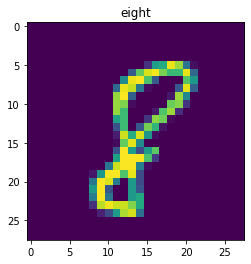

In [87]:
labels_map = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine",
}

train_indices = np.zeros((10, train_examples))
test_indices = np.zeros((10, test_examples))
train_labels = np.array(trainset.targets)
test_labels = np.array(testset.targets)

# taking first 100 images of each class
for i in range(10):
  train_idx = np.where(train_labels == i)[0]
  test_idx = np.where(test_labels == i)[0]

  train_indices[i] = np.array(train_idx[0:train_examples])
  test_indices[i] = np.array(test_idx[0:test_examples])

train_indices = train_indices.astype(int)
test_indices = test_indices.astype(int)

print(dataset[train_indices[0, 0]])

train_data = []
test_data = []
for i in range(10):
  for j in range(train_examples):
    I, label = dataset[train_indices[i, j]]
    I = np.array(I)
    train_data.append([I, label])
  for j in range(test_examples):
    I, label = dataset[test_indices[i, j]]
    I = np.array(I)
    test_data.append([I, label])

sample_idx = torch.randint(len(dataset), size=(1,)).item()
img, label = dataset[sample_idx]
print(img, label)
plt.title(labels_map[label])
plt.imshow(img)

I = np.array(img)

ground_truth = np.identity(10)

### Activation Functions

In [88]:
def sigmoid(I):
  I = -1 * I
  return 1/(1 + np.exp(I))

In [89]:
def reLU(I):
  I[I < 0] = 0
  return I

In [90]:
def tanh(I):
  return (np.exp(I) - np.exp(-1 * I))/(np.exp(I) + np.exp(-1 * I))

In [91]:
def PreLU(I, a=0.01):
  I[I <= 0] = a * I[I <= 0]
  return I

### Convolution 

In [92]:
def convolution1(I, kernel, padding=True, stride=1, activation='relu'):

  N1, M1 = I.shape
  N2, M2 = kernel.shape

  if padding == True:
    padding = N2 // 2
    # zero padding
    padded = np.zeros((N1 + padding * 2, M1 + padding * 2))
    padded[padding:-padding, padding:-padding] = I
  else:
    padding = 0
    padded = I

  result = np.zeros((int((N1 - N2 + 2 * padding)/stride + 1), int((M1 - M2 + 2 * padding)/stride + 1)))

  # for faster calculations
  for i in range(padding, N1 + padding):
    if i % stride == 0:
      for j in range(padding, M1 + padding):
        if j % stride == 0:
          # handling odd and even sized kernels
          if N2 % 2 != 0:
            result[i - padding, j - padding] = (np.multiply(kernel, padded[i - padding: i + padding + 1, j - padding: j + padding + 1]).sum())
          else:
            result[i - padding, j - padding] = (np.multiply(kernel, padded[i - padding: i + padding, j - padding: j + padding]).sum())

  # getting rid of the bottom right extra padding in case of even-sized kernels
  if N2 % 2 == 0:
    result = result[0:N1, 0:M1]


  if activation == 'sigmoid':
    result = sigmoid(result) 
  elif activation == 'relu':
    result = reLU(result)
  elif activation == 'prelu':
    result = PreLU(result) 
  elif activation == 'tanh':
    result = tanh(result) 

  gradient_relu = np.zeros(result.shape)
  gradient_relu = result > 0
  gradient_relu = gradient_relu.astype(int)
  
  return result, gradient_relu

In [93]:
def convolution2(I, kernel, padding=True, stride=1, activation='relu'):

  _, N1, M1 = I.shape
  _, N2, M2 = kernel.shape


  if padding == True:
    padding = N2 // 2
    # zero padding
    padded = np.zeros((I.shape[0], N1 + padding * 2, M1 + padding * 2))
    for i in range(I.shape[0]):
      padded[i, padding:-padding, padding:-padding] = I[i, :, :]
  else:
    padding = 0
    padded = np.zeros((I.shape[0], N1 + padding * 2, M1 + padding * 2))
    padded = I.copy()
  

  result = np.zeros((int((N1 - N2 + 2 * padding)/stride + 1), int((M1 - M2 + 2 * padding)/stride + 1)))

    
  # for faster calculations
  for i in range(padding, N1 + padding):
    if i % stride == 0:
      for j in range(padding, M1 + padding):
        if j % stride == 0:
          # handling odd and even sized kernels
          if N2 % 2 != 0:
            result[i - padding, j - padding] = (np.multiply(kernel, padded[:, i - padding: i + padding + 1, j - padding: j + padding + 1]).sum())
          else:
            result[i - padding, j - padding] = (np.multiply(kernel, padded[:, i - padding: i + padding, j - padding: j + padding]).sum())

  # getting rid of the bottom right extra padding in case of even-sized kernels
  if N2 % 2 == 0:
    result = result[0:N1, 0:M1]

  if activation == 'sigmoid':
    result = sigmoid(result) 
  elif activation == 'relu':
    result = reLU(result)
  elif activation == 'prelu':
    result = PreLU(result) 
  elif activation == 'tanh':
    result = tanh(result) 

  gradient_relu = np.zeros(result.shape)
  gradient_relu = result > 0
  gradient_relu = gradient_relu.astype(int)
  
  return result, gradient_relu

###Kernels

In [94]:
def randomKernel1(kernel_size):
  M = np.random.random((kernel_size, kernel_size))
  # kernel = [M, M, M]
  kernel = M
  kernel = np.array(M)
  kernel = kernel / kernel.sum()
  return kernel

def randomKernel2(kernel_size):
  M = np.random.random((kernel_size, kernel_size))
  # stack 16 times
  kernel = [M, M, M, M]
  kernel = np.array(kernel)
  kernel = kernel / kernel.sum()
  return kernel

### Pooling 

In [95]:
def pooling(I, pool_size, stride=2, poolType='max'):

  height, width = I.shape

  heightRes = int((height - pool_size)/stride + 1)
  widthRes = int((width - pool_size)/stride + 1)
  output = np.zeros((heightRes, widthRes))
  mask_indices = np.zeros(output.shape, dtype=(np.int64, 2))

  for i in range(0, height, stride):
    if i + pool_size > height:
      break
    for j in range(0, width, stride):
      if j + pool_size > width:
        break
      temp = I[i : i + pool_size, j : j + pool_size]
      output[int(i/stride), int(j/stride)] = np.amax(temp)
      index = np.unravel_index(np.argmax(I[i : i + pool_size, j : j + pool_size]), I[i : i + pool_size, j : j + pool_size].shape)
      index = np.array(index)
      index[0] = index[0] + i
      index[1] = index[1] + j
      mask_indices[int(i/stride), int(j/stride)] = index
  return output, mask_indices

In [96]:
def pooling_backward(shape, mask_indices, gradients):
  output = np.zeros(shape)
  index = 0
  for i in range(gradients.shape[0]):
    for j in range(gradients.shape[1]):
      x, y = mask_indices[index]
      index = index + 1
      output[x, y] = gradients[i, j]

  return output

### Flattening

In [97]:
def flatten(I):
  return np.ravel(I).reshape(I.shape[0], -1)

### MLP

In [98]:
class MLP():
  def __init__(self, input=196, hidden=49, output=10, activation='relu', learning_rate=0.05, param=0.9):

    self.input = input 
    self.hidden = hidden
    self.output = output
    self.activation = activation
    self.learning_rate = learning_rate
    self.param = param

    self.w1 = np.random.randn(input, hidden) # weights for the hidden layer
    self.w2 = np.random.randn(hidden, output) # weights for the output layer
    self.b1 = np.random.randn(1, hidden) # bias for the hidden layer
    self.b2 = np.random.randn(1, output) # bias for the output layer

    self.z1 = None
    self.a1 = None # activation of the hidden layer
    self.z2 = None
    self.a2 = None # activation of output

  def d_sigmoid(self, x):
    return x * (1 - x)

  def d_reLU(self, x):
    output = x.copy()
    output[x <= 0] = 0
    output[x > 0] = 1
    return output
  
  def forward(self, X):
    self.z1 = np.dot(X, self.w1) + self.b1

    if self.activation == 'sigmoid':
      self.a1 = sigmoid(self.z1) 
    elif self.activation == 'relu':
      self.a1 = reLU(self.z1)
    elif self.activation == 'prelu':
      self.a1 = PreLU(self.z1) 
    elif self.activation == 'tanh':
      self.a1 = tanh(self.z1) 

    self.z2 = np.dot(self.a1, self.w2) + self.b2
    self.a2 = self.z2.copy() #softmax has been done directly in the training function
    return self.a2
    

  def update(self, delta_w1, delta_w2, delta_b1, delta_b2, velocities, g, variant):
    if variant == 'vanillaSGD':
      self.w2 = self.w2 - self.learning_rate * delta_w2
      self.w1 = self.w1 - self.learning_rate * delta_w1

      self.b2 = self.b2 - self.learning_rate * delta_b2
      self.b1 = self.b1 - self.learning_rate * delta_b1
    
    elif variant == 'momentum':
      velocities[0] = self.param * velocities[0] - self.learning_rate * delta_w2
      self.w2 = self.w2 + velocities[0]
      velocities[1] = self.param * velocities[1] - self.learning_rate * delta_w1
      self.w1 = self.w1 + velocities[1]

      velocities[2] = self.param * velocities[2] - self.learning_rate * delta_b2
      self.b2 = self.b2 + velocities[2]
      velocities[3] = self.param * velocities[3] - self.learning_rate * delta_b1
      self.b1 = self.b1 + velocities[3]
    
    elif variant == 'RMSProp':
      delta = 0.0005
      g[0] = self.param * g[0] + (1 - self.param) * (delta_w2 * delta_w2)
      self.w2 = self.w2 - (self.learning_rate / np.sqrt(delta + g[0])) * delta_w2
      g[1] = self.param * g[1] + (1 - self.param) * (delta_w1 * delta_w1)
      self.w1 = self.w1 - (self.learning_rate / np.sqrt(delta + g[1])) * delta_w1

      g[2] = self.param * g[2] + (1 - self.param) * (delta_b2 * delta_b2)
      self.b2 = self.b2 - (self.learning_rate / np.sqrt(delta + g[2])) * delta_b2
      g[3] = self.param * g[3] + (1 - self.param) * (delta_b1 * delta_b1)
      self.b1 = self.b1 - (self.learning_rate / np.sqrt(delta + g[3])) * delta_b1
    return velocities, g
      

  # backward pass to update weights
  def backward(self, X, labels):
    X = X.reshape(1, X.shape[0])

    # delta for weights corressponding to the outer layer
    delta_w2 = -2 * np.dot(self.a1.T, (labels - self.a2))
    # delta for weights corressponding to the inner layer
    delta_w1 = -2 * np.dot(X.T, (np.dot((labels - self.a2) * self.d_reLU(self.a2), self.w2.T)) * self.d_reLU(self.a1))

    # delta for bias corressponding to the outer layer
    delta_b2 = -2 * (labels - self.a2)
    delta_b2 = np.dot(np.ones(delta_b2.shape[0]), delta_b2)
    # delta for bias corressponding to the inner layer
    delta_b1 = -2 * np.dot(((labels - self.a2) * self.d_reLU(self.a2)), self.w2.T) * self.d_reLU(self.a1)
    delta_b1 = np.dot(np.ones(delta_b1.shape[0]), delta_b1)

    return delta_w1, delta_w2, delta_b1, delta_b2

### Softmax

In [99]:
def softmax(x):
  sm = np.exp(x - np.max(x))
  return sm / sm.sum()

### Cross Entropy

In [100]:
def cross_entropy(p, q):
  loss = -1 * np.sum(p * np.log(q))
  loss = loss / float(q.shape[0])
  return loss

### Graph Loss

In [101]:
def plot_loss(train_loss, test_loss, graph_title):
  plt.plot(train_loss, label="Training Loss")
  plt.plot(test_loss, label="Training Loss")
  plt.title(graph_title)
  plt.xlabel("Epoch")
  plt.ylabel("Cross Entropy Loss")
  plt.legend()
  plt.show()

# Training

In [102]:
class CNN():
  def __init__(self, lr=0.001, k1_no=4, k2_no=4, k1_size=5, k2_size=5, epochs=15, param=0.9, variant='vanillaSGD'):
    self.k1_no, self.k2_no, self.k1_size, self.k2_size = k1_no, k2_no, k1_size, k2_size
    self.lr = lr
    self.epochs = epochs
    self.param = param
    self.variant = variant

    self.layer1 = []
    self.layer2 = []
    self.mask_indices1 = []
    self.layer3 = []
    self.layer4 = []
    self.mask_indices2 = []

    self.layer6 = MLP(learning_rate=self.lr)

    # update params
    self.kernels_1 = []
    self.kernels_2 = []
    self.velocities = [] # momentum
    self.g = [] # RMSProp


  def feedforward(self, I):

    # layer 1
    for i in range(self.k1_no):
      # generate kernels if this is the first pass
      if len(self.kernels_1) < self.k1_no:
        kernel = randomKernel1(kernel_size=self.k1_size)
        self.kernels_1.append(kernel)
      else:
        kernel = self.kernels_1[0]
      conv1, grad_relu = convolution1(I, kernel, padding=True, stride=1, activation='relu')
      self.layer1.append(conv1)
    L_1 = np.array(self.layer1)
    
    # layer 2
    for img in L_1:
      pool, mask_indices = pooling(img, pool_size=2, stride=2, poolType='max')
      self.mask_indices1.append(mask_indices)
      self.layer2.append(pool)
    L_2 = np.array(self.layer2)

    # layer 3
    for i in range(self.k2_no):
      if len(self.kernels_2) < self.k2_no:
        kernel = kernel = randomKernel2(kernel_size=self.k2_size)
        self.kernels_2.append(kernel)
      else:
        kernel = self.kernels_2[0]
      self.layer3.append(convolution2(L_2, kernel, padding=True, stride=1, activation='relu')[0])
    L_3 = np.array(self.layer3)

    # layer 4
    for img in L_3:
      pool, mask_indices = pooling(img, pool_size=2, stride=2, poolType='max')
      self.mask_indices2.append(mask_indices)
      self.layer4.append(pool)
    L_4 = np.array(self.layer4)

    # layer 5
    L_5 = L_4.flatten()

    # layer 6
    L_6 = self.layer6.forward(L_5)

    softmax_output = softmax(L_6)

    return L_1, L_2, L_3, L_4, L_5, L_6, softmax_output
  
  def update(self, kernels_2, grad_conv2, kernels_1, grad_conv1):
    if self.variant == 'vanillaSGD':
      self.kernels_2 = kernels_2 - self.lr * grad_conv2
      self.kernels_1 = kernels_1 - self.lr * grad_conv1
    
    elif self.variant == 'momentum':
      self.velocities[4] = self.param * self.velocities[4] - self.lr * grad_conv2
      self.kernels_2 = kernels_2 + self.velocities[4]

      self.velocities[5] = self.param * self.velocities[5] - self.lr * grad_conv1
      self.kernels_1 = kernels_1 + self.velocities[5]
    
    elif self.variant == 'RMSProp':
      delta = 0.0005
      self.g[4] = self.param * self.g[4] + (1 - self.param) * (grad_conv2 * grad_conv2)
      self.kernels_2 = kernels_2 - (self.lr / np.sqrt(delta + self.g[4])) * grad_conv2
  
      self.g[5] = self.param * self.g[5] + (1 - self.param) * (grad_conv1 * grad_conv1)
      self.kernels_1 = kernels_1 - (self.lr / np.sqrt(delta + self.g[5])) * grad_conv1


  def train(self, train_data, test_data):
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

    first_epoch_flatten = []
    last_epoch_flatten = []

    for epoch in range(self.epochs):
      print("Epoch", epoch + 1)
      np.random.shuffle(train_data)
      
      train_correct_matches = 0
      train_avg_loss = 0

      test_correct_matches = 0
      test_avg_loss = 0

      # training
      for example in range(len(train_data)):
        I = train_data[example][0]
        I = (I - np.min(I)) / (np.max(I) - np.min(I))
        label = train_data[example][1]

        # forward pass
        l1, l2, l3, l4, l5, l6, O = self.feedforward(I)

        kernels_2 = np.array(self.kernels_2)
        kernels_1 = np.array(self.kernels_1)
        # for momentum and RMSprop
        self.velocities = [
                  np.zeros(self.layer6.w2.shape),
                  np.zeros(self.layer6.w1.shape),
                  np.zeros(self.layer6.b2.shape),
                  np.zeros(self.layer6.b1.shape),
                  np.zeros(kernels_2.shape),
                  np.zeros(kernels_1.shape)]

        self.g = [
                  np.zeros(self.layer6.w2.shape),
                  np.zeros(self.layer6.w1.shape),
                  np.zeros(self.layer6.b2.shape),
                  np.zeros(self.layer6.b1.shape),
                  np.zeros(kernels_2.shape),
                  np.zeros(kernels_1.shape)]

        # cross entropy loss
        loss = cross_entropy(ground_truth[label], O)
        train_avg_loss += loss

        # backward pass
        
        # MLP
        # differentiate cross entropy loss
        d_CE = O.copy()
        d_CE[0, label] = d_CE[0, label] - 1
        grad_to_hidden = np.sum(d_CE * self.layer6.w2, axis=1)
        grad_to_flatten  = np.sum(grad_to_hidden * self.layer6.w1, axis=1)
        
        # mlp update weights
        delta_w1, delta_w2, delta_b1, delta_b2 = self.layer6.backward(l5, ground_truth[label])

        # flatten
        grad_to_pool2 = grad_to_flatten.reshape(l4.shape)

        # max pooling 2
        grad_to_conv2 = np.zeros(l3.shape)
        for index in range(len(self.mask_indices2)):
          for i in range(l4.shape[1]):
            for j in range(l4.shape[2]):
              x, y = self.mask_indices2[index][i, j]
              grad_to_conv2[index, x, y] = grad_to_pool2[index, i, j]

        # convolution 2
        # gradient for the previous layer
        grad_to_pool1 = np.zeros(l2.shape)
        for i in range(len(l2)):
          grad_to_pool1[i, :, :] = convolution1(l2[i], grad_to_conv2[i], padding=True, stride=1, activation='relu')[0]
        
        # update kernels
        grad_conv2 = np.zeros(kernels_2.shape)
        for i in range(self.k2_no):
          kernel = np.fliplr(np.flipud(self.kernels_2[i]))
          grad_conv2[i] = convolution2(kernel, grad_to_conv2, padding=True, stride=1, activation='relu')[0]

        # max pooling 1
        grad_to_conv1 = np.zeros(l1.shape)
        for index in range(len(self.mask_indices1)):
          for i in range(l2.shape[1]):
            for j in range(l2.shape[2]):
              x, y = self.mask_indices1[index][i, j]
              grad_to_conv1[index, x, y] = grad_to_pool1[index, i, j]

        # convolution 1
        # update kernels
        grad_conv1 = np.zeros(kernels_1.shape)
        for i in range(self.k1_no):
          kernel = np.fliplr(np.flipud(kernels_1[i]))
          grad_conv1[i] = convolution1(kernel, grad_to_conv1[i], padding=True, stride=1, activation='relu')[0]

        # update weights
        self.velocities, self.g = self.layer6.update(delta_w1, delta_w2, delta_b1, delta_b2, self.velocities, self.g, self.variant)
        self.update(kernels_2, grad_conv2, kernels_1, grad_conv1)

        # reset class variables
        self.layer1 = []
        self.layer2 = []
        self.mask_indices1 = []
        self.layer3 = []
        self.layer4 = []
        self.mask_indices2 = []

        # accuracy
        predictions = O == np.amax(O)
        predictions = predictions.astype(int)[0]
        if (predictions == ground_truth[label]).all():
          train_correct_matches += 1

        # visualise activation maps for the last image in the last epoch
        if epoch == self.epochs - 1 and example == len(train_data) - 1:
          print(example)
          fig, axis = plt.subplots(1, 2, figsize=(10, 60), tight_layout=True)
          axis[0].imshow(l1[0])
          axis[0].set_title("Conv Layer 1 Activation Map (index 0)")
          axis[1].imshow(l3[0])
          axis[1].set_title("Conv Layer 2 Activation Map (index 0)")

      
      # testing
      for example in range(len(test_data)):
        I = test_data[example][0]
        I = (I - np.min(I)) / (np.max(I) - np.min(I))
        label = test_data[example][1]
        # forward pass
        l1, l2, l3, l4, l5, l6, O = self.feedforward(I)
        if epoch == 0:
          first_epoch_flatten.append([l5, label])
        if epoch == self.epochs - 1:
          last_epoch_flatten.append([l5, label])
        
        # loss
        # cross entropy loss
        loss = cross_entropy(ground_truth[label], O)
        test_avg_loss += loss

        # reset class variables
        self.layer1 = []
        self.layer2 = []
        self.mask_indices1 = []
        self.layer3 = []
        self.layer4 = []
        self.mask_indices2 = []

        # accuracy
        predictions = O == np.amax(O)
        predictions = predictions.astype(int)[0]
        if (predictions == ground_truth[label]).all():
          test_correct_matches += 1

      accuracy = (train_correct_matches / len(train_data)) * 100
      print("Train Accuracy:", accuracy)
      train_acc.append(accuracy)

      train_avg_loss = (train_avg_loss / len(train_data)) * 100
      print("Train Loss:", train_avg_loss)
      train_loss.append(train_avg_loss)

      accuracy = (test_correct_matches / len(test_data)) * 100
      print("Test Accuracy:", accuracy)
      test_acc.append(accuracy)

      test_avg_loss = (test_avg_loss / len(test_data)) * 100
      print("Test Loss:", test_avg_loss)
      test_loss.append(test_avg_loss)
      print()

    return train_loss, test_loss, train_acc, test_acc, first_epoch_flatten, last_epoch_flatten

Epoch 1
Train Accuracy: 10.0
Train Loss: 299.9301749961806
Test Accuracy: 5.0
Test Loss: 246.51543633198204

Epoch 2
Train Accuracy: 5.0
Train Loss: 232.6847490373769
Test Accuracy: 5.0
Test Loss: 230.47352477566503

Epoch 3
Train Accuracy: 9.0
Train Loss: 231.27867167170572
Test Accuracy: 10.0
Test Loss: 230.8231834409562

Epoch 4
Train Accuracy: 9.0
Train Loss: 231.37473839518285
Test Accuracy: 15.0
Test Loss: 229.9949795563093

Epoch 5
Train Accuracy: 5.0
Train Loss: 231.28343650463123
Test Accuracy: 15.0
Test Loss: 230.40375855544372

Epoch 6
Train Accuracy: 5.0
Train Loss: 231.2980069382312
Test Accuracy: 15.0
Test Loss: 229.49446913233572

Epoch 7
Train Accuracy: 7.000000000000001
Train Loss: 231.83967586628788
Test Accuracy: 15.0
Test Loss: 229.5824059206226

Epoch 8
Train Accuracy: 8.0
Train Loss: 231.21325361374318
Test Accuracy: 5.0
Test Loss: 230.91132153823648

Epoch 9
Train Accuracy: 8.0
Train Loss: 231.31229621169462
Test Accuracy: 5.0
Test Loss: 230.47459460754663

Epoch

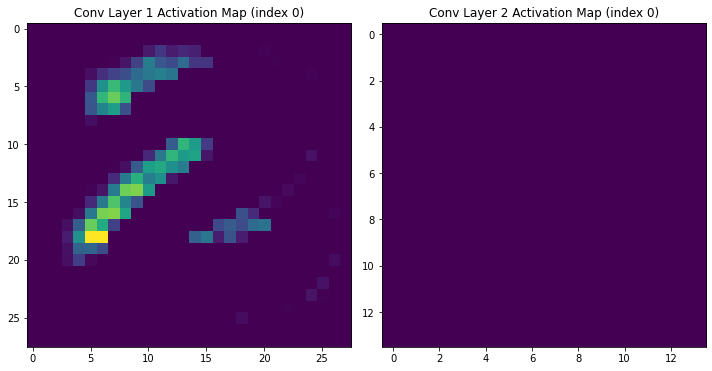

In [103]:
cnn_vanilla = CNN(epochs=epochs, variant='vanillaSGD')
train_loss, test_loss, train_acc, test_acc, first_epoch, last_epoch = cnn_vanilla.train(train_data, test_data)

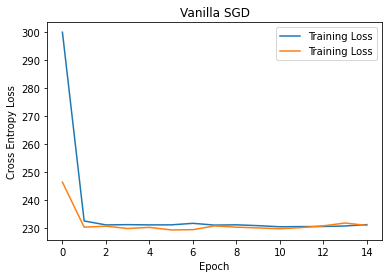

In [104]:
plot_loss(train_loss, test_loss, "Vanilla SGD")

Epoch 1
Train Accuracy: 14.000000000000002
Train Loss: 304.84334013632
Test Accuracy: 15.0
Test Loss: 234.14286144085133

Epoch 2
Train Accuracy: 11.0
Train Loss: 231.30899357736777
Test Accuracy: 5.0
Test Loss: 230.21632208474233

Epoch 3
Train Accuracy: 14.000000000000002
Train Loss: 230.32058297190136
Test Accuracy: 5.0
Test Loss: 232.45417878593506

Epoch 4
Train Accuracy: 7.000000000000001
Train Loss: 231.73039834457097
Test Accuracy: 15.0
Test Loss: 229.7389238928981

Epoch 5
Train Accuracy: 6.0
Train Loss: 231.5580042797055
Test Accuracy: 5.0
Test Loss: 231.6970022679056

Epoch 6
Train Accuracy: 8.0
Train Loss: 231.6284754263804
Test Accuracy: 15.0
Test Loss: 230.03449352237863

Epoch 7
Train Accuracy: 8.0
Train Loss: 230.99544060643652
Test Accuracy: 5.0
Test Loss: 232.73198134767603

Epoch 8
Train Accuracy: 10.0
Train Loss: 230.6520619973851
Test Accuracy: 10.0
Test Loss: 229.10175525030542

Epoch 9
Train Accuracy: 7.000000000000001
Train Loss: 231.51826683860781
Test Accuracy

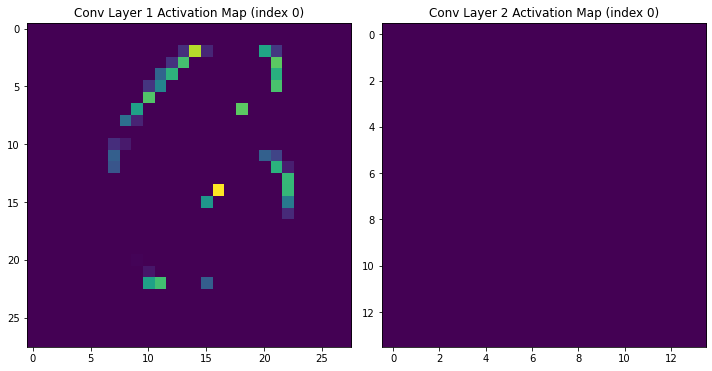

In [105]:
cnn_momentem = CNN(epochs=epochs, variant='momentum')
train_loss_momentum, test_loss_momentum, train_acc_momentum, test_acc_momentum, first_epoch_momentum, last_epoch_momentum = cnn_momentem.train(train_data, test_data)

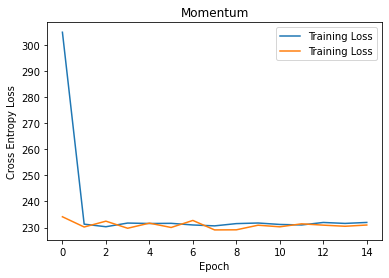

In [106]:
plot_loss(train_loss_momentum, test_loss_momentum, "Momentum")

Epoch 1
Train Accuracy: 9.0
Train Loss: 340.93797039000657
Test Accuracy: 5.0
Test Loss: 233.65569210830824

Epoch 2
Train Accuracy: 10.0
Train Loss: 230.57161503134043
Test Accuracy: 5.0
Test Loss: 230.26915742654518

Epoch 3
Train Accuracy: 8.0
Train Loss: 230.62200983827296
Test Accuracy: 15.0
Test Loss: 229.99504984461606

Epoch 4
Train Accuracy: 9.0
Train Loss: 230.69756775796137
Test Accuracy: 15.0
Test Loss: 230.0389435385255

Epoch 5
Train Accuracy: 5.0
Train Loss: 230.82886371893605
Test Accuracy: 5.0
Test Loss: 230.29317344096881

Epoch 6
Train Accuracy: 13.0
Train Loss: 230.24248327666763
Test Accuracy: 5.0
Test Loss: 230.86651608130887

Epoch 7
Train Accuracy: 11.0
Train Loss: 229.94547231388296
Test Accuracy: 15.0
Test Loss: 229.86832896744085

Epoch 8
Train Accuracy: 8.0
Train Loss: 230.73918528625916
Test Accuracy: 15.0
Test Loss: 230.0780207948675

Epoch 9
Train Accuracy: 15.0
Train Loss: 229.95779715980885
Test Accuracy: 5.0
Test Loss: 230.50078694878658

Epoch 10
Trai

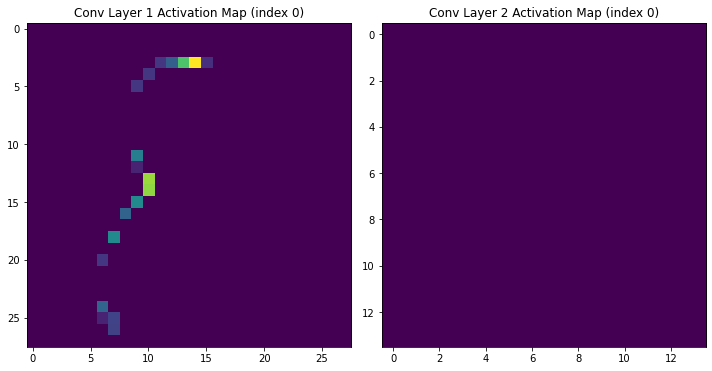

In [107]:
cnn_rms = CNN(epochs=epochs, variant='RMSProp')
train_loss_rms, test_loss_rms, train_acc_rms, test_acc_rms, first_epoch_rms, last_epoch_rms = cnn_rms.train(train_data, test_data)

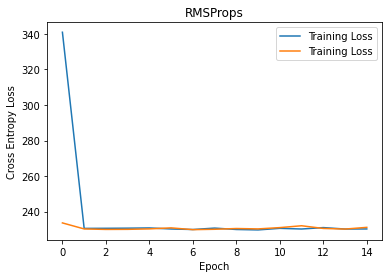

In [108]:
plot_loss(train_loss_rms, test_loss_rms, "RMSProps")

# t-SNE Plots

In [117]:
# The assignment document mentioned we are allowed to use open source code for the t-SNE plots.
# Hence, the t-SNE code was referenced from the following website: 
# https://www.datatechnotes.com/2020/11/tsne-visualization-example-in-python.html
import pandas as pd
def plot_tsne(values, plot_title, state):
  # flatten_values, labels,
  flatten_values = np.zeros((len(values), values[0][0].shape[0]))
  labels = np.zeros(len(values))
  for i in range(len(values)):
    flatten_values[i] = values[i][0]
    labels[i] = values[i][1]

  tsne = TSNE(n_components=2, random_state=state)
  z = tsne.fit_transform(flatten_values)
  df = pd.DataFrame()
  df["labels"] = labels
  df["comp-1"] = z[:,0]
  df["comp-2"] = z[:,1]

  sns.scatterplot(x="comp-1", y="comp-2", hue=df.labels.tolist(), palette=sns.color_palette("hls", 10), data=df).set(title=plot_title)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


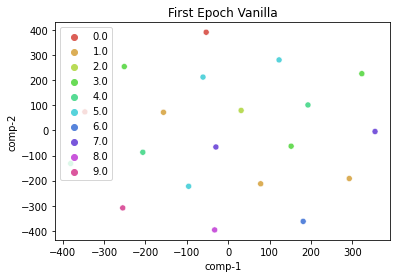

In [118]:
plot_tsne(first_epoch, "First Epoch Vanilla", 42)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


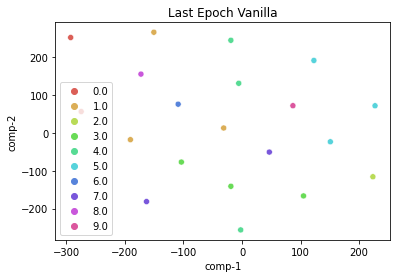

In [119]:
plot_tsne(last_epoch, "Last Epoch Vanilla", 43)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


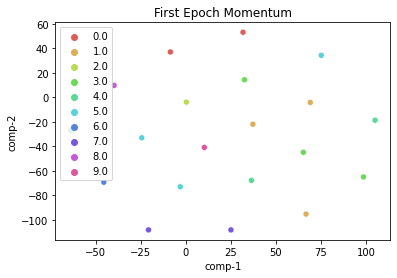

In [120]:
plot_tsne(first_epoch_momentum, "First Epoch Momentum", 44)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


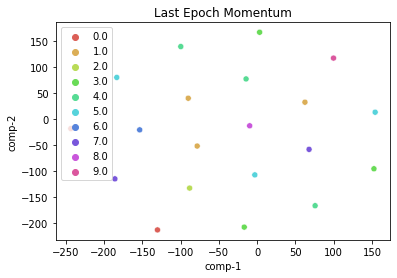

In [121]:
plot_tsne(last_epoch_momentum, "Last Epoch Momentum", 45)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


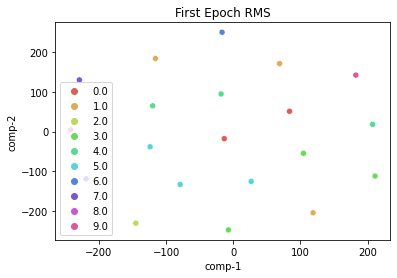

In [122]:
plot_tsne(first_epoch_rms, "First Epoch RMS", 46)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


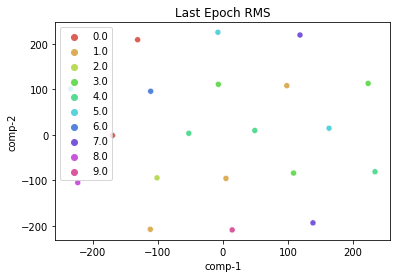

In [123]:
plot_tsne(last_epoch_rms, "Last Epoch RMS", 47)